In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils as ut
import os

## Analysis of the invasion probability ratio

In [10]:
# these two string must be passed during the execution of invasion_prob.exe
data_dir = '../data/inv_prob/plotkin3/'

### Setting the parameters

In [12]:
params = dict()

# General parameters
params['N_init_cond'] = 3000 # -- Number of trajectories at each threshold
params['relax_step'] = 5000 # -- Number of steps for the relaxation of the initial condition
params['thresholds'] = [2, 5, 10, 20, 50, 100, 200, 400, 700, 1000, 2000, 5000, 10000] 

# Fixed parameters
rho2 = 1
chi2 = 1
s = 0.0
params['M'] = 500 # -- Population size scale

# List of parameters
chi1s = np.array([1/3, 1, 3])
rho1s = np.array(np.logspace(np.log10(0.2),np.log10(5),9))

params['N_processes'] = len(chi1s)*len(rho1s)

### Export for LV

In [18]:
count = 1
params['process_type'] = 'lv2'
for c in chi1s:
    for r in rho1s:
        params['rhos'] = [r, rho2]
        params['chis'] = [c, chi2]
        params['fs'] = [1, 1-s]
        params['carrying_cap'] = params['M'] / chi2 / params['fs'][1]
        ut.write_params(params, data_dir, str(count)+'_param.txt')
        params['rhos'] = [rho2, r]
        params['chis'] = [chi2, c]
        params['fs'] = [1-s, 1]
        params['carrying_cap'] = params['M'] / c / params['fs'][1]
        ut.write_params(params, data_dir, str(count)+'sw_param.txt')
        count += 1

### Export for chemostat

In [8]:
count = 1
params['process_type'] = 'chem2'
for c in chi1s:
    for r in rho1s:
        params['deltas'] = [r, rho2 / (1-s)]
        params['etas'] = [r, rho2]
        params['alphas'] = [c, chi2]
        params['carrying_cap'] = params['M'] / chi2
        ut.write_params(params, data_dir, str(count)+'_param.txt')
        params['deltas'] = [rho2 / (1-s), r]
        params['etas'] = [rho2, r]
        params['alphas'] = [chi2, c]
        params['carrying_cap'] = params['M'] / c
        ut.write_params(params, data_dir, str(count)+'sw_param.txt')
        count += 1

### Export for plotkin

In [13]:
count = 1
params['process_type'] = 'plotkin2'
for r in rho1s:
    params['betas'] = [r, rho2]
    params['alpha'] = 0.5
    params['carrying_cap'] = params['M'] * (1/params['alpha']-1)
    ut.write_params(params, data_dir, str(count)+'_param.txt')
    params['betas'] = [rho2, r]
    ut.write_params(params, data_dir, str(count)+'sw_param.txt')
    count += 1

### Importing the results and comparing with theory

In [2]:
plot_dir = '../plots/'
data_dir = '../data/inv_prob/'

In [3]:
def log_inv_prob_ratio(sM, r, c):
    if r != c:
        aux1 = sM * (r-1)/(r-c)
        aux2 = (sM*r*(c-1)-(1-r*c)*(r-c))/(c-r)**2 * np.log(c/r)
        return aux1+aux2
    else:
        return (sM*(r+1)/2+1-r**2)/r

In [3]:
ratio_at_sM = dict()
cs_at_sM, rs_at_sM = dict(), dict()
name_list = ['LV0', 'LV1', 'LV2']
n_max_files=25

for name in name_list:
    for i in range(1,n_max_files+1):
        try:
            inv_p = float(ut.read_inv_p(data_dir+name+'/'+str(i)+'_inv_p.txt'))
            inv_p_sw = float(ut.read_inv_p(data_dir+name+'/'+str(i)+'sw_inv_p.txt'))
            tparam = ut.read_params(data_dir+name+'/'+str(i)+'_param.txt')
            sMt = (tparam['fs'][0]-tparam['fs'][1])/tparam['fs'][1]* tparam['M']/tparam['chis'][1]
            if sMt not in ratio_at_sM:
                ratio_at_sM[sMt] = [inv_p / inv_p_sw]
                cs_at_sM[sMt] = [tparam['chis'][0]/tparam['chis'][1]]
                rs_at_sM[sMt] = [tparam['rhos'][0]/tparam['rhos'][1]]
            else:
                ratio_at_sM[sMt].append(inv_p / inv_p_sw)
                cs_at_sM[sMt].append(tparam['chis'][0]/tparam['chis'][1])
                rs_at_sM[sMt].append(tparam['rhos'][0]/tparam['rhos'][1])
        except:
            pass
            #print(i)

In [19]:
ratio_at_sM2 = dict()
cs_at_sM2, rs_at_sM2 = dict(), dict()
name_list = ['chem0', 'chem1', 'chem2']
n_max_files=25

for name in name_list:
    for i in range(1,n_max_files+1):
        try:
            inv_p = float(ut.read_inv_p(data_dir+name+'/'+str(i)+'_inv_p.txt'))
            inv_p_sw = float(ut.read_inv_p(data_dir+name+'/'+str(i)+'sw_inv_p.txt'))
            tparam = ut.read_params(data_dir+name+'/'+str(i)+'_param.txt')
            rho0, rho1 = tparam['deltas'][0], tparam['deltas'][1]
            fs0, fs1 = tparam['etas'][0]*tparam['alphas'][0]/tparam['deltas'][0], tparam['etas'][1]*tparam['alphas'][1]/tparam['deltas'][1]
            chi0, chi1 = tparam['deltas'][0]/tparam['etas'][0], tparam['deltas'][1]/tparam['etas'][1]
            sMt = (fs0-fs1)/fs1* tparam['M']/chi1
            if sMt not in ratio_at_sM2:
                ratio_at_sM2[sMt] = [inv_p / inv_p_sw]
                cs_at_sM2[sMt] = [chi0/chi1]
                rs_at_sM2[sMt] = [rho0/rho1]
            else:
                ratio_at_sM2[sMt].append(inv_p / inv_p_sw)
                cs_at_sM2[sMt].append(chi0/chi1)
                rs_at_sM2[sMt].append(rho0/rho1)
        except:
            pass
            #print(i)

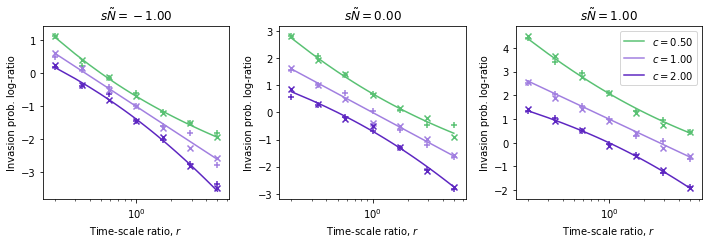

In [29]:
fig, axs = plt.subplots(1,len(ratio_at_sM2), figsize=(10,3.5))

colors = ['#59C173', '#a17fe0', '#5D26C1']
for i in range(len(ratio_at_sM2.keys())):
    sM = list(ratio_at_sM2.keys())[i]
    axs[i].set_title(r'$s \tilde{N}=%3.2f$'%sM)
    axs[i].set_xlabel('Time-scale ratio, $r$')
    axs[i].set_ylabel('Invasion prob. log-ratio')
    axs[i].set_xscale('log')
    unique_cs = set(cs_at_sM2[sM])
    count_c=0
    #unique_cs = [1.0,2.0,4.0]
    for c in unique_cs:
        ratio, r = np.array([]), np.array([])
        for k in range(len(ratio_at_sM2[sM])):
            if cs_at_sM2[sM][k] == c:
                ratio = np.append(np.log(ratio_at_sM2[sM][k]), ratio)
                r = np.append(rs_at_sM2[sM][k], r)
        axs[i].scatter(r, ratio, marker='+', c=colors[count_c])
        x = np.linspace(min(r), max(r))
        axs[i].plot(x, [log_inv_prob_ratio(sM, ar, c) for ar in x], label=r'$c=%3.2f$'%c, c=colors[count_c])
        count_c+=1
        
for i in range(len(ratio_at_sM.keys())):
    sM = list(ratio_at_sM.keys())[i]
    axs[i].set_title(r'$s \tilde{N}=%3.2f$'%sM)
    axs[i].set_xlabel('Time-scale ratio, $r$')
    axs[i].set_ylabel('Invasion prob. log-ratio')
    axs[i].set_xscale('log')
    unique_cs = set(cs_at_sM[sM])
    #unique_cs = [1.0,2.0,4.0]
    count_c=0
    for c in unique_cs:
        ratio, r = np.array([]), np.array([])
        for k in range(len(ratio_at_sM[sM])):
            if cs_at_sM[sM][k] == c:
                ratio = np.append(np.log(ratio_at_sM[sM][k]), ratio)
                r = np.append(rs_at_sM[sM][k], r)
        axs[i].scatter(r, ratio, marker='x', c=colors[count_c])
        count_c += 1

plt.legend()
plt.tight_layout()
plt.savefig(plot_dir+'p_inv_log_ratio.png', dpi=200, transparent=True)

In [18]:
beta2 = np.array([1,2,3,4,5])
data_dir = '../data/inv_prob/plotkin2/'

inv_p, inv_p_sw = [], []

count = 1
for i in range(len(beta2)):
    aux_p, aux_p_sw = [], []
    p = ut.read_params(data_dir + str(count) + '_param.txt')
    aux_p.append(float(ut.read_inv_p(data_dir + str(count) + '_inv_p.txt')))
    p = ut.read_params(data_dir + str(count) + 'sw_param.txt')
    aux_p_sw.append(float(ut.read_inv_p(data_dir + str(count) + 'sw_inv_p.txt')))
    count+=1
    inv_p.append(aux_p)
    inv_p_sw.append(aux_p_sw)

    
inv_p = np.array(inv_p)
inv_p_sw = np.array(inv_p_sw)

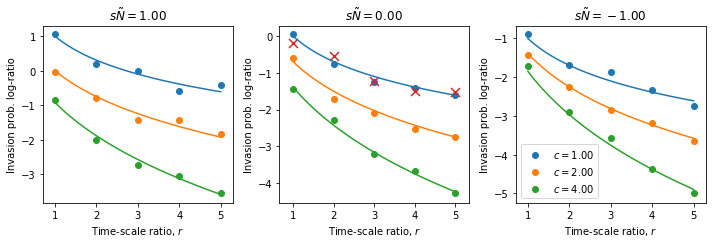

In [30]:
fig, axs = plt.subplots(1,len(ratio_at_sM), figsize=(10,3.5))

for i in range(len(ratio_at_sM.keys())):
    sM = list(ratio_at_sM.keys())[i]
    axs[i].set_title(r'$s \tilde{N}=%3.2f$'%sM)
    axs[i].set_xlabel('Time-scale ratio, $r$')
    axs[i].set_ylabel('Invasion prob. log-ratio')
    #unique_cs = set(cs_at_sM[sM])
    unique_cs = [1.0,2.0,4.0]
    for c in unique_cs:
        ratio, r = np.array([]), np.array([])
        for k in range(len(ratio_at_sM[sM])):
            if cs_at_sM[sM][k] == c:
                ratio = np.append(np.log(ratio_at_sM[sM][k]), ratio)
                r = np.append(rs_at_sM[sM][k], r)
        axs[i].scatter(r, ratio, label=r'$c=%3.2f$'%c)
        x = np.linspace(min(r), max(r))
        axs[i].plot(x, [log_inv_prob_ratio(sM, ar, c) for ar in x])
    

axs[1].scatter(beta2, np.log(inv_p_sw/inv_p), marker='x', s=80, label='Plotkin')
    
plt.legend()
plt.tight_layout()
plt.savefig(plot_dir+'p_inv_log_ratio.png', dpi=200, transparent=True)

### Analytical study

In [89]:
r = 10
sMs = np.linspace(-10,10,99)
cs = np.logspace(np.log10(0.1), np.log10(10),99)

x_mat, y_mat, z_mat = [], [], []
for c in cs:
    aux2_x_mat, aux2_y_mat, aux2_z_mat = [], [], []
    for sM in sMs:
        aux2_x_mat.append(c)
        aux2_y_mat.append(sM)
        aux2_z_mat.append(log_inv_prob_ratio(sM,r,c))
    x_mat.append(aux2_x_mat)
    y_mat.append(aux2_y_mat)
    z_mat.append(aux2_z_mat)

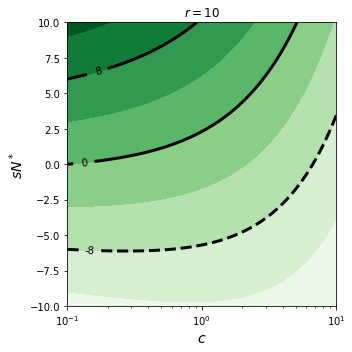

In [90]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.set_xscale('log')
ax.set_ylabel(r'$s N^*$', fontsize=14)
ax.set_xlabel(r'$c$', fontsize=14)
ax.set_title(r'$r={}$'.format(r))
cntf = ax.contourf(x_mat, y_mat, z_mat, cmap='Greens')
cnt = ax.contour(x_mat, y_mat, z_mat, levels=[-8,0,8], colors='black', linewidths=3)
ax.clabel(cnt, fmt='%2.0f')

#cb = plt.colorbar(cntf, ax=ax)
#cb.set_label(r'$\log(\;p_{inv}/\tilde{p}_{inv}\;)$', fontsize=14)
plt.tight_layout()
#plt.savefig('../plots/Inv_prob/log_pratio_rfix.svg',dpi=200)

In [80]:
sM = 2
rs = np.logspace(np.log10(0.1), np.log10(10),99)
cs = np.logspace(np.log10(0.1), np.log10(10),99)

x_mat, y_mat, z_mat = [], [], []
for c in cs:
    aux2_x_mat, aux2_y_mat, aux2_z_mat = [], [], []
    for r in rs:
        aux2_x_mat.append(c)
        aux2_y_mat.append(r)
        aux2_z_mat.append(log_inv_prob_ratio(sM,r,c))
    x_mat.append(aux2_x_mat)
    y_mat.append(aux2_y_mat)
    z_mat.append(aux2_z_mat)

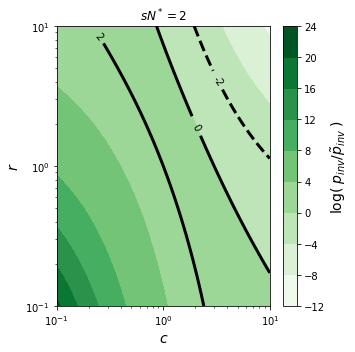

In [81]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$c$', fontsize=14)
ax.set_ylabel(r'$r$', fontsize=14)
ax.set_title(r'$s N^*={}$'.format(sM))
cntf = ax.contourf(x_mat, y_mat, z_mat, cmap='Greens')
cnt = ax.contour(x_mat, y_mat, z_mat, levels=[-2,0,2], colors='black', linewidths=3)
ax.clabel(cnt, fmt='%2.0f')

cb = plt.colorbar(cntf, ax=ax)
cb.set_label(r'$\log(\;p_{inv}/\tilde{p}_{inv}\;)$', fontsize=14)
plt.tight_layout()
#plt.savefig('../plots/Inv_prob/log_pratio_sNfix.svg',dpi=200)

In [84]:
c=0.1
rs = np.logspace(np.log10(0.1), np.log10(10),99)
sMs = np.linspace(-10,10,99)

x_mat, y_mat, z_mat = [], [], []
for sM in sMs:
    aux2_x_mat, aux2_y_mat, aux2_z_mat = [], [], []
    for r in rs:
        aux2_x_mat.append(r)
        aux2_y_mat.append(sM)
        aux2_z_mat.append(log_inv_prob_ratio(sM,r,c))
    x_mat.append(aux2_x_mat)
    y_mat.append(aux2_y_mat)
    z_mat.append(aux2_z_mat)

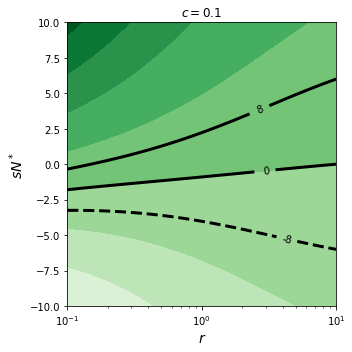

In [85]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.set_xscale('log')
ax.set_ylabel(r'$s N^*$', fontsize=14)
ax.set_xlabel(r'$r$', fontsize=14)
ax.set_title(r'$c={}$'.format(c))
cntf = ax.contourf(x_mat, y_mat, z_mat, cmap='Greens')
cnt = ax.contour(x_mat, y_mat, z_mat, levels=[-8,0,8], colors='black', linewidths=3)
ax.clabel(cnt, fmt='%2.0f')

#cb = plt.colorbar(cntf, ax=ax)
#cb.set_label(r'$\log(\;p_{inv}/\tilde{p}_{inv}\;)$', fontsize=14)
plt.tight_layout()
#plt.savefig('../plots/Inv_prob/log_pratio_cfix.svg',dpi=200)

### Invasion through mutations

In [14]:
def log_minv_prob_ratio(sM, r, c):
    if r != c:
        aux1 = sM * (r-1)/(r-c)
        aux2 = (1 + (sM*r*(c-1)-(1-r*c)*(r-c))/(c-r)**2) * np.log(c/r)
        return aux1+aux2
    else:
        return (sM*(r+1)/2+1-r**2)/r

In [35]:
r = 1
sMs = np.linspace(-1,2,99)
cs = np.linspace(0.5,2,99)

x_mat, y_mat, z_mat = [], [], []
for c in cs:
    aux2_x_mat, aux2_y_mat, aux2_z_mat = [], [], []
    for sM in sMs:
        aux2_x_mat.append(c)
        aux2_y_mat.append(sM)
        aux2_z_mat.append(log_minv_prob_ratio(sM,r,c))
    x_mat.append(aux2_x_mat)
    y_mat.append(aux2_y_mat)
    z_mat.append(aux2_z_mat)

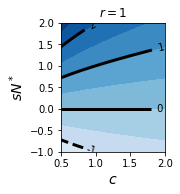

In [37]:
fig, ax = plt.subplots(1,1,figsize=(2.6,2.8))

ax.set_ylabel(r'$s N^*$', fontsize=14)
ax.set_xlabel(r'$c$', fontsize=14)
ax.set_title(r'$r={}$'.format(r))
cntf = ax.contourf(x_mat, y_mat, z_mat, levels=np.linspace(-2,3,11), cmap='Blues')
cnt = ax.contour(x_mat, y_mat, z_mat, levels=[-1,0,1,2], colors='black', linewidths=3)
ax.clabel(cnt, fmt='%2.0f')

#cb = plt.colorbar(cntf, ax=ax)
#cb.set_label(r'$\log(\;p_{inv}/\tilde{p}_{inv}\;)$', fontsize=14)
plt.tight_layout()
plt.savefig('../plots/Inv_prob/log_mpratio_rfix.svg',dpi=200)

In [38]:
sM = 0
rs = np.linspace(0.5,2,99)
cs = np.linspace(0.2,5,99)

x_mat, y_mat, z_mat = [], [], []
for c in cs:
    aux2_x_mat, aux2_y_mat, aux2_z_mat = [], [], []
    for r in rs:
        aux2_x_mat.append(c)
        aux2_y_mat.append(r)
        aux2_z_mat.append(log_minv_prob_ratio(sM,r,c))
    x_mat.append(aux2_x_mat)
    y_mat.append(aux2_y_mat)
    z_mat.append(aux2_z_mat)

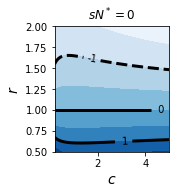

In [40]:
fig, ax = plt.subplots(1,1,figsize=(2.6,2.8))

ax.set_xlabel(r'$c$', fontsize=14)
ax.set_ylabel(r'$r$', fontsize=14)
ax.set_title(r'$s N^*={}$'.format(sM))
cntf = ax.contourf(x_mat, y_mat, z_mat, levels=np.linspace(-2,2,9), cmap='Blues')
cnt = ax.contour(x_mat, y_mat, z_mat, levels=[-1,0,1], colors='black', linewidths=3)
ax.clabel(cnt, fmt='%2.0f')

#cb = plt.colorbar(cntf, ax=ax)
#cb.set_label(r'$\log(\;p_{inv}/\tilde{p}_{inv}\;)$', fontsize=14)
plt.tight_layout()
plt.savefig('../plots/Inv_prob/log_mpratio_sNfix.svg',dpi=200)

In [41]:
c=1
rs = np.linspace(0.5,2,99)
sMs = np.linspace(-1,2,99)

x_mat, y_mat, z_mat = [], [], []
for sM in sMs:
    aux2_x_mat, aux2_y_mat, aux2_z_mat = [], [], []
    for r in rs:
        aux2_x_mat.append(r)
        aux2_y_mat.append(sM)
        aux2_z_mat.append(log_minv_prob_ratio(sM,r,c))
    x_mat.append(aux2_x_mat)
    y_mat.append(aux2_y_mat)
    z_mat.append(aux2_z_mat)

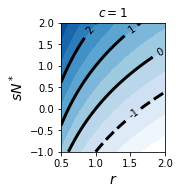

In [43]:
fig, ax = plt.subplots(1,1,figsize=(2.6,2.8))

ax.set_ylabel(r'$s N^*$', fontsize=14)
ax.set_xlabel(r'$r$', fontsize=14)
ax.set_title(r'$c={}$'.format(c))
cntf = ax.contourf(x_mat, y_mat, z_mat, levels=np.linspace(-2,4,13), cmap='Blues')
cnt = ax.contour(x_mat, y_mat, z_mat, levels=[-1,0,1,2], colors='black', linewidths=3)
ax.clabel(cnt, fmt='%2.0f')

#cb = plt.colorbar(cntf, ax=ax)
#cb.set_label(r'$\log(\;p_{inv}/\tilde{p}_{inv}\;)$', fontsize=14)
plt.tight_layout()
plt.savefig('../plots/Inv_prob/log_mpratio_cfix.svg',dpi=200)